In [29]:
# # 하고자 하는 것
# 1. shrinkage parameter theta= 0.75로 설정해서
# 2. corr이 아닌 (1-theta)corr + theta * I를 MVO에 적용

# # 원하는 결과
# - EPO를 MVO에 넣었을 때 최적 가중치 ; 이걸 EPO weight로 재설정할 것

In [30]:
# !pip install cvxpy
# !pip install tqdm
# !pip install yfinance
# !pip install PyPortfolioOpt

In [31]:
import numpy as np
import cvxpy as cp
import cplex
from tqdm import tqdm

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as pdr
import yfinance as yf

from dateutil.relativedelta import relativedelta
from datetime import datetime

In [32]:
mkt = pd.read_csv('../new_market.csv')
mkt['pricingDate'] = pd.to_datetime(mkt['pricingDate'])
mkt.set_index('pricingDate', inplace = True)
mkt

,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
pricingDate,,,,,,,,,,,,,,,,,,,,,
2018-05-01,66.24,43.36,42.2750,102.07,58.82,26.876666,151.92,224.08,88.86,45.03,...,191.85,46.65,76.95,50.64,70.37,86.64,116.95,136.78,55.05,83.40
2018-05-02,65.91,42.24,44.1425,100.37,57.85,26.310000,150.71,221.10,88.30,44.43,...,191.03,46.54,76.80,50.59,68.88,80.20,117.46,133.12,55.19,79.90
2018-05-03,66.34,42.11,44.2225,100.28,57.93,25.983333,151.73,226.05,87.91,43.60,...,191.62,46.48,76.54,49.24,69.63,82.67,115.18,133.54,54.45,80.38
2018-05-04,67.00,42.86,45.9575,100.17,58.74,26.276666,153.44,228.51,90.27,43.86,...,192.41,46.39,76.90,49.99,70.08,82.43,116.22,134.67,55.46,81.56
2018-05-07,67.39,42.44,46.2900,99.63,59.32,26.376666,152.30,230.99,90.50,43.69,...,191.91,46.13,77.74,46.92,70.02,83.11,116.99,137.48,55.51,82.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-04,111.67,12.73,173.6600,147.69,95.65,80.460000,309.39,518.42,173.79,73.47,...,88.21,56.63,111.50,33.30,91.22,123.53,109.69,230.94,33.33,170.99
2023-10-05,110.35,12.85,174.9100,147.45,96.20,81.640000,309.66,516.44,172.10,73.13,...,89.49,56.48,108.99,32.18,90.14,121.84,109.30,222.54,33.40,172.00
2023-10-06,110.64,12.76,177.4900,148.24,96.88,82.180000,312.19,526.68,173.97,72.86,...,92.41,57.35,107.17,32.48,90.97,119.46,110.91,223.85,33.69,175.58


In [33]:
# GPT 종목 (GPT weight)
stocks_15 = {
    "AAPL": 0.084, "AMZN": 0.074, "NVDA": 0.064, "JPM": 0.054, "PG": 0.054,
    "PFE": 0.064, "JNJ": 0.064, "KO": 0.054, "XOM": 0.064, "NEE": 0.074,
    "GOOGL": 0.084, "MSFT": 0.084, "TSLA": 0.074, "NKE": 0.054, "BAC": 0.054
}

stocks_30 = {
    "MSFT": 0.067, "AMZN": 0.067, "NVDA": 0.067, "AAPL": 0.067, "GOOGL": 0.067,
    "ADBE": 0.067, "JNJ": 0.05, "PFE": 0.05, "MRK": 0.05, "ABT": 0.05, 
    "PG": 0.05, "KO": 0.05, "JPM": 0.05, "GS": 0.05, "CAT": 0.025, 
    "CVX": 0.025, "XOM": 0.025, "BA": 0.025, "TSLA": 0.025, "NEE": 0.025, 
    "NKE": 0.005, "VZ": 0.005, "CRM": 0.005, "UNH": 0.005, "WMT": 0.005, 
    "QCOM": 0.005, "BAC": 0.005, "V": 0.005, "MCD": 0.005, "INTC": 0.005
}

stocks_45 = {
    "AAPL": 0.05, "GOOGL": 0.04, "MSFT": 0.04, "NVDA": 0.03, "AMD": 0.03, 
    "ORCL": 0.02, "CRM": 0.02, "INTC": 0.01, "CSCO": 0.01, "JPM": 0.04, 
    "GS": 0.03, "BAC": 0.03, "MS": 0.02, "AXP": 0.02, "C": 0.01,
    "JNJ": 0.03, "UNH": 0.03, "PFE": 0.02, "ABBV": 0.02, "TSLA": 0.02, 
    "AMGN": 0.02, "GILD": 0.01, "PG": 0.03, "KO": 0.03, "NKE": 0.02, 
    "PEP": 0.02, "COST": 0.02, "WMT": 0.02, "TGT": 0.01, "XOM": 0.025, 
    "CVX": 0.025, "NEE": 0.02, "DUK": 0.01, "SO": 0.01, "SLB": 0.01,
    "MMM": 0.02, "CAT": 0.02, "HON": 0.02, "GE": 0.02, "ADP": 0.02,
    "AMZN": 0.02, "META": 0.02, "HD": 0.02, "VZ": 0.01, "MRK": 0.01
}

In [34]:
# mkt에서 데이터 가져오는 함수
# input : 가져오고자 하는 종목의 티커, 시작 날짜, 종료 날짜

def downloads(dict, start_date, end_date):
    data = pd.DataFrame()
    a = pd.DataFrame()
    tickers = list(dict.keys())

    for ticker in tqdm(tickers):
        a = mkt.loc[start_date:end_date, ticker]
        data = pd.concat([data, a], axis=1)

    return data

## GMV + EPO

In [35]:
# GMV 함수 + shrinkage parameter

def gmv_epo(dict):

    data = downloads(dict, "2018-05-01", "2023-04-30")  # mkt 데이터에서 일별 주가데이터 가져오기
    ret = data.pct_change().dropna()
    
    num_assets = data.shape[1] # 종목 개수가 나와야함
    weights = cp.Variable((num_assets,1)) # 종목 개수랑 같아야함
    # corr_mat = np.corr(ret.values.T) # 개별 종목 별 기대수익률을 구해서 Correlation Matrix를 만듬
    corr_mat = ret.corr()

    theta = 0.75 # shrinkage parameter
    identity_matrix = np.eye(corr_mat.shape[0])  # identity matrix
    corr_mat = (1-theta) * corr_mat + theta * identity_matrix # corr_mat에 shrinkage parameter 적용

    print(corr_mat)
    
    obj = cp.Minimize(cp.quad_form(weights, corr_mat)) # 목적식 설정
    
    # 가중치 합 = 1, weights >= 0, min weight ~ max weight 범위 제약
    const = [cp.sum(weights) == 1, weights >= 0, ((1/num_assets))/2 <= weights, weights <= 2*(1/num_assets)] # 제약식 설정, 공매도 원하면 위에 주석 가져다 옆으로 복붙하면됨
    
    problem = cp.Problem(obj, const) # 문제 정의
    problem.solve(verbose=False, solver=cp.CPLEX) # 문제 풀기
    
    if problem.status == "optimal":
        w_opt = np.array(weights.value).flatten()
        print("Optimal")
        # print(gmv_weights.value[:5])
        
        # print(max(gmv_weights.value)) # 가장 큰 weight를 보고싶으면 이거 주석 해제
    else:
        print("It isn't optimal")

    return w_opt

In [36]:
gmv_epo_15 = gmv_epo(stocks_15)
gmv_epo_30 = gmv_epo(stocks_30)
gmv_epo_45 = gmv_epo(stocks_45)

100%|██████████| 15/15 [00:00<00:00, 374.92it/s]

           AAPL      AMZN      NVDA       JPM        PG       PFE       JNJ  \
AAPL   1.000000  0.162708  0.165228  0.115260  0.105833  0.085721  0.102081   
AMZN   0.162708  1.000000  0.158854  0.077746  0.067514  0.058525  0.065138   
NVDA   0.165228  0.158854  1.000000  0.096170  0.072743  0.060656  0.064179   
JPM    0.115260  0.077746  0.096170  1.000000  0.096231  0.093459  0.101936   
PG     0.105833  0.067514  0.072743  0.096231  1.000000  0.108820  0.147669   
PFE    0.085721  0.058525  0.060656  0.093459  0.108820  1.000000  0.136088   
JNJ    0.102081  0.065138  0.064179  0.101936  0.147669  0.136088  1.000000   
KO     0.102968  0.060207  0.066680  0.131955  0.158811  0.108129  0.137851   
XOM    0.084538  0.053009  0.069701  0.149049  0.059866  0.071230  0.079168   
NEE    0.107051  0.076916  0.086087  0.093081  0.142689  0.090049  0.117448   
GOOGL  0.173473  0.171445  0.162045  0.114996  0.093347  0.080398  0.092239   
MSFT   0.190759  0.178629  0.176718  0.116618  0.117

Optimal


100%|██████████| 30/30 [00:00<00:00, 428.48it/s]

           MSFT      AMZN      NVDA      AAPL     GOOGL      ADBE       JNJ  \
MSFT   1.000000  0.178629  0.176718  0.190759  0.198295  0.199154  0.109446   
AMZN   0.178629  1.000000  0.158854  0.162708  0.171445  0.168519  0.065138   
NVDA   0.176718  0.158854  1.000000  0.165228  0.162045  0.169209  0.064179   
AAPL   0.190759  0.162708  0.165228  1.000000  0.173473  0.170253  0.102081   
GOOGL  0.198295  0.171445  0.162045  0.173473  1.000000  0.177272  0.092239   
ADBE   0.199154  0.168519  0.169209  0.170253  0.177272  1.000000  0.081645   
JNJ    0.109446  0.065138  0.064179  0.102081  0.092239  0.081645  1.000000   
PFE    0.093141  0.058525  0.060656  0.085721  0.080398  0.071077  0.136088   
MRK    0.096947  0.051030  0.054182  0.084939  0.077860  0.074851  0.144355   
ABT    0.152420  0.109577  0.120084  0.136036  0.129699  0.135038  0.143023   
PG     0.117668  0.067514  0.072743  0.105833  0.093347  0.089958  0.147669   
KO     0.110425  0.060207  0.066680  0.102968  0.098

Optimal


100%|██████████| 45/45 [00:00<00:00, 428.47it/s]

           AAPL     GOOGL      MSFT      NVDA       AMD      ORCL       CRM  \
AAPL   1.000000  0.173473  0.190759  0.165228  0.141190  0.131646  0.147520   
GOOGL  0.173473  1.000000  0.198295  0.162045  0.135988  0.122949  0.154663   
MSFT   0.190759  0.198295  1.000000  0.176718  0.145928  0.147855  0.175011   
NVDA   0.165228  0.162045  0.176718  1.000000  0.182669  0.114248  0.152037   
AMD    0.141190  0.135988  0.145928  0.182669  1.000000  0.100704  0.128619   
ORCL   0.131646  0.122949  0.147855  0.114248  0.100704  1.000000  0.118808   
CRM    0.147520  0.154663  0.175011  0.152037  0.128619  0.118808  1.000000   
INTC   0.147289  0.142352  0.155760  0.149051  0.119021  0.121165  0.116367   
CSCO   0.149346  0.137552  0.156108  0.125427  0.110654  0.144420  0.120372   
JPM    0.115260  0.114996  0.116618  0.096170  0.079993  0.128010  0.093097   
GS     0.130424  0.129059  0.130325  0.115233  0.096480  0.127436  0.107459   
BAC    0.116084  0.117547  0.118250  0.099243  0.085

Optimal


In [37]:
print('GMV EPO 15 weights')
print(list(gmv_epo_15))

print('GMV EPO 30 weights')
print(list(gmv_epo_30))

print('GMV EPO 45 weights')
print(list(gmv_epo_45))

GMV EPO 15 weights
[0.04575246928786821, 0.07265377471492239, 0.06481175209487042, 0.05609762627137712, 0.0719435734229653, 0.08771670571734723, 0.07277777173189208, 0.06312539328973277, 0.08609507668538831, 0.07221233969635621, 0.05010272070811802, 0.03828500762569085, 0.10055629310834088, 0.06129593107749074, 0.05657356456763967]
GMV EPO 30 weights
[0.01666666774419816, 0.042227409477106695, 0.03118097512246346, 0.01666667168358331, 0.01809943946174481, 0.02570202818687248, 0.035080295142533816, 0.052582684453145526, 0.0475986044981093, 0.022988231711774245, 0.03608309079046335, 0.027444963001599185, 0.01940313030454212, 0.017845787304226788, 0.0336990887241052, 0.03478235727173764, 0.044706637080323186, 0.0401698232395637, 0.06666666228078902, 0.03819709421977127, 0.0283698072324536, 0.05348428364961278, 0.03498396614637049, 0.028482865710042066, 0.05711849959966492, 0.03681044243477318, 0.020125552595200585, 0.01666666803231992, 0.02878298920491861, 0.027383283695990274]
GMV EPO 45

In [38]:
# 누적 수익률 함수
# bool에 True를 넣으면 gpt gmv epo opt 데이터로 실행, False이면 GPT로 이미 가져와있는거 실행

def cum_ret_gmv_epo(dic, w_opt, start_date, end_date):  
    
    result = dict(zip(list(dic.keys()), w_opt))
    data = downloads(dic, start_date, end_date)
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(result))
    cum_ret = (1 + pfo_ret).cumprod()

    return cum_ret

def cum_ret_gpt(dic, start_date, end_date):  

    data = downloads(dic, start_date, end_date)
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(dic))
    cum_ret = (1 + pfo_ret).cumprod()        
        
    return cum_ret

### in-sample 누적 수익률 확인 2018-05-01 ~ 2023-04-30

In [39]:
cum_15 = cum_ret_gmv_epo(stocks_15, gmv_epo_15, '2018-05-01', '2023-04-30')
cum_30 = cum_ret_gmv_epo(stocks_30, gmv_epo_30, '2018-05-01', '2023-04-30')
cum_45 = cum_ret_gmv_epo(stocks_45, gmv_epo_45, '2018-05-01', '2023-04-30')

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:00<00:00, 459.08it/s]


In [40]:
gpt_15_in = cum_ret_gpt(stocks_15, '2018-05-01', '2023-04-30')
gpt_30_in = cum_ret_gpt(stocks_30, '2018-05-01', '2023-04-30')
gpt_45_in = cum_ret_gpt(stocks_45, '2018-05-01', '2023-04-30')

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:00<00:00, 454.44it/s]


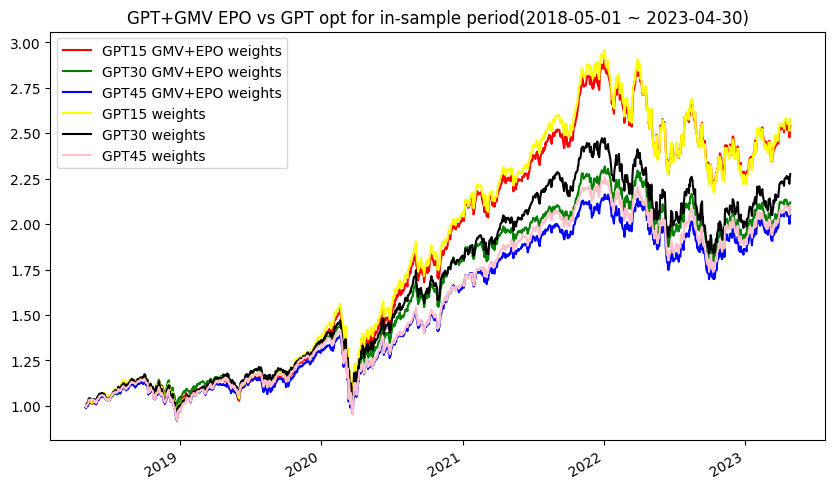

In [41]:
# Log

plt.figure(figsize=(10,6))
plt.title("GPT+GMV EPO vs GPT opt for in-sample period(2018-05-01 ~ 2023-04-30)")

cum_15.plot(label='GPT15 GMV+EPO weights', color='red')
cum_30.plot(label='GPT30 GMV+EPO weights', color='green')
cum_45.plot(label='GPT45 GMV+EPO weights', color='blue')
gpt_15_in.plot(label='GPT15 weights', color='yellow')
gpt_30_in.plot(label='GPT30 weights', color='black')
gpt_45_in.plot(label='GPT45 weights', color='pink')

plt.legend()
plt.show()

### out-of-sample 누적 수익률 확인 2023-05-01 ~ 2023-10-10

In [42]:
cum_15 = cum_ret_gmv_epo(stocks_15, gmv_epo_15, '2023-05-01', '2023-10-10')
cum_30 = cum_ret_gmv_epo(stocks_30, gmv_epo_30, '2023-05-01', '2023-10-10')
cum_45 = cum_ret_gmv_epo(stocks_45, gmv_epo_45, '2023-05-01', '2023-10-10')

100%|██████████| 15/15 [00:00<00:00, 833.13it/s]


100%|██████████| 45/45 [00:00<00:00, 882.15it/s]


In [43]:
gpt_15_out = cum_ret_gpt(stocks_15, '2023-04-29', '2023-10-10')
gpt_30_out = cum_ret_gpt(stocks_30, '2023-04-29', '2023-10-10')
gpt_45_out = cum_ret_gpt(stocks_45, '2023-04-29', '2023-10-10')

100%|██████████| 15/15 [00:00<00:00, 833.15it/s]


100%|██████████| 45/45 [00:00<00:00, 882.15it/s]


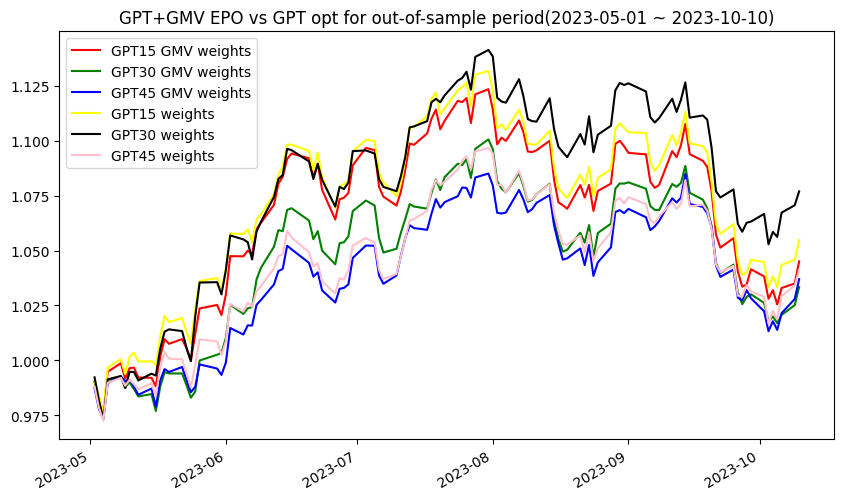

In [44]:
# Log

plt.figure(figsize=(10,6))
plt.title("GPT+GMV EPO vs GPT opt for out-of-sample period(2023-05-01 ~ 2023-10-10)")

cum_15.plot(label='GPT15 GMV weights', color='red')
cum_30.plot(label='GPT30 GMV weights', color='green')
cum_45.plot(label='GPT45 GMV weights', color='blue')
gpt_15_out.plot(label='GPT15 weights', color='yellow')
gpt_30_out.plot(label='GPT30 weights', color='black')
gpt_45_out.plot(label='GPT45 weights', color='pink')

plt.legend()
plt.show()

## Max Sharpe + EPO

In [45]:
# Max Sharpe 함수 + shrinkage parameter
def max_sharpe_epo(dict):
    df = downloads(dict, "2018-05-01", "2023-04-30")

    mu = expected_returns.mean_historical_return(df) # pfo mean 
    S = risk_models.sample_cov(df) # cov
    stds = np.sqrt(np.diag(S)) # cov의 표준편차
    S = risk_models.cov_to_corr(S) # cov -> corr
    theta = 0.75 # shrinkage parameter
    identity_matrix = np.eye(S.shape[0])  # identity matrix
    S = (1-theta)* S + theta * identity_matrix # shrinkage 반영된 correlation matrix
    S = risk_models.corr_to_cov(S, stds)
    ef = EfficientFrontier(mu, S)

    n_assets = len(mu)  # 자산 수
    min_weights = 0.5 * 1 / n_assets  # 각 자산별 최소 weight
    max_weights = 2 * 1 / n_assets

    for asset in mu.index:
        num = mu.index.get_loc(asset)
        ef.add_constraint(lambda w: w[num] <= max_weights)
        ef.add_constraint(lambda w: w[num] >= min_weights)
    
    ef.add_constraint(lambda w: w.sum() == 1)

    w_opt = ef.max_sharpe() # Max Sharpe ratio가 되는 weights 찾기
    # print('w_opt:', w_opt)
    w_clean = ef.clean_weights()
    # print('w_clean',w_clean.values())
    ef.portfolio_performance(verbose=True) 
    # print(w_clean) # 가중치 확인
    max_weight_asset = max(w_clean, key=w_clean.get)
    max_weight_value = w_clean[max_weight_asset]

    print()
    print("가장 큰 가중치를 가진 자산:", max_weight_asset)
    print("가장 큰 가중치:", max_weight_value)

    return w_clean  #.values()

In [46]:
msp_epo_15 = max_sharpe_epo(stocks_15)
msp_epo_30 = max_sharpe_epo(stocks_30)
msp_epo_45 = max_sharpe_epo(stocks_45)

100%|██████████| 15/15 [00:00<00:00, 394.65it/s]

Expected annual return: 22.6%
Annual volatility: 16.0%
Sharpe Ratio: 1.29

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.13333


100%|██████████| 30/30 [00:00<00:00, 405.32it/s]


Expected annual return: 17.7%
Annual volatility: 13.0%
Sharpe Ratio: 1.21

가장 큰 가중치를 가진 자산: MSFT
가장 큰 가중치: 0.06667


100%|██████████| 45/45 [00:00<00:00, 257.08it/s]


Expected annual return: 17.2%
Annual volatility: 12.1%
Sharpe Ratio: 1.25

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.04444


In [47]:
print('MAX sharpe EPO 15 tickers')
print(list(msp_epo_15))

print('MAX sharpe EPO 30 tickers')
print(list(msp_epo_30))

print('MAX sharpe EPO 45 tickers')
print(list(msp_epo_45))

MAX sharpe EPO 15 tickers
['AAPL', 'AMZN', 'NVDA', 'JPM', 'PG', 'PFE', 'JNJ', 'KO', 'XOM', 'NEE', 'GOOGL', 'MSFT', 'TSLA', 'NKE', 'BAC']
MAX sharpe EPO 30 tickers
['MSFT', 'AMZN', 'NVDA', 'AAPL', 'GOOGL', 'ADBE', 'JNJ', 'PFE', 'MRK', 'ABT', 'PG', 'KO', 'JPM', 'GS', 'CAT', 'CVX', 'XOM', 'BA', 'TSLA', 'NEE', 'NKE', 'VZ', 'CRM', 'UNH', 'WMT', 'QCOM', 'BAC', 'V', 'MCD', 'INTC']
MAX sharpe EPO 45 tickers
['AAPL', 'GOOGL', 'MSFT', 'NVDA', 'AMD', 'ORCL', 'CRM', 'INTC', 'CSCO', 'JPM', 'GS', 'BAC', 'MS', 'AXP', 'C', 'JNJ', 'UNH', 'PFE', 'ABBV', 'TSLA', 'AMGN', 'GILD', 'PG', 'KO', 'NKE', 'PEP', 'COST', 'WMT', 'TGT', 'XOM', 'CVX', 'NEE', 'DUK', 'SO', 'SLB', 'MMM', 'CAT', 'HON', 'GE', 'ADP', 'AMZN', 'META', 'HD', 'VZ', 'MRK']


In [48]:
msp_epo_15_w = max_sharpe_epo(stocks_15).values()
msp_epo_30_w = max_sharpe_epo(stocks_30).values()
msp_epo_45_w = max_sharpe_epo(stocks_45).values()

100%|██████████| 15/15 [00:00<00:00, 312.43it/s]


Expected annual return: 22.6%
Annual volatility: 16.0%
Sharpe Ratio: 1.29

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.13333


100%|██████████| 30/30 [00:00<00:00, 441.08it/s]

Expected annual return: 17.7%


Annual volatility: 13.0%
Sharpe Ratio: 1.21

가장 큰 가중치를 가진 자산: MSFT
가장 큰 가중치: 0.06667


100%|██████████| 45/45 [00:00<00:00, 463.81it/s]

Expected annual return: 17.2%
Annual volatility: 12.1%
Sharpe Ratio: 1.25

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.04444


In [49]:
print('MAX sharpe EPO 15 weights')
print(list(msp_epo_15_w))

print('MAX sharpe EPO 30 weights')
print(list(msp_epo_30_w))

print('MAX sharpe EPO 45 weights')
print(list(msp_epo_45_w))

MAX sharpe EPO 15 weights
[0.13333, 0.03333, 0.09331, 0.03333, 0.13333, 0.03333, 0.03333, 0.04542, 0.03333, 0.08777, 0.03333, 0.13333, 0.10683, 0.03333, 0.03333]
MAX sharpe EPO 30 weights
[0.06667, 0.01667, 0.06667, 0.06667, 0.01667, 0.01667, 0.01667, 0.01667, 0.06667, 0.03705, 0.06667, 0.01667, 0.01667, 0.01667, 0.01667, 0.01667, 0.01667, 0.01667, 0.06667, 0.0536, 0.01667, 0.01667, 0.01667, 0.0605, 0.06667, 0.01667, 0.01667, 0.01667, 0.06552, 0.01667]
MAX sharpe EPO 45 weights
[0.04444, 0.02423, 0.04444, 0.04444, 0.04444, 0.04444, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.04444, 0.01111, 0.01111, 0.04444, 0.01111, 0.01111, 0.04444, 0.0192, 0.01111, 0.04444, 0.04444, 0.04444, 0.04444, 0.01111, 0.01111, 0.04444, 0.01111, 0.02323, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.04444]


In [50]:
# 누적 수익률 함수
def max_sharpe_epo_cum_ret(dic, result, start_date, end_date):
    data = downloads(dic, start_date, end_date)
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(result))
    cum_ret = (1 + pfo_ret).cumprod()

    return cum_ret

### in-sample 누적 수익률 확인 2018-05-01 ~ 2023-04-30

In [51]:
# in-sample
msf_15 = max_sharpe_epo_cum_ret(stocks_15, msp_epo_15, '2018-05-01', '2023-04-30')
msf_30 = max_sharpe_epo_cum_ret(stocks_30, msp_epo_30, '2018-05-01', '2023-04-30')
msf_45 = max_sharpe_epo_cum_ret(stocks_45, msp_epo_45, '2018-05-01', '2023-04-30')

100%|██████████| 45/45 [00:00<00:00, 459.08it/s]


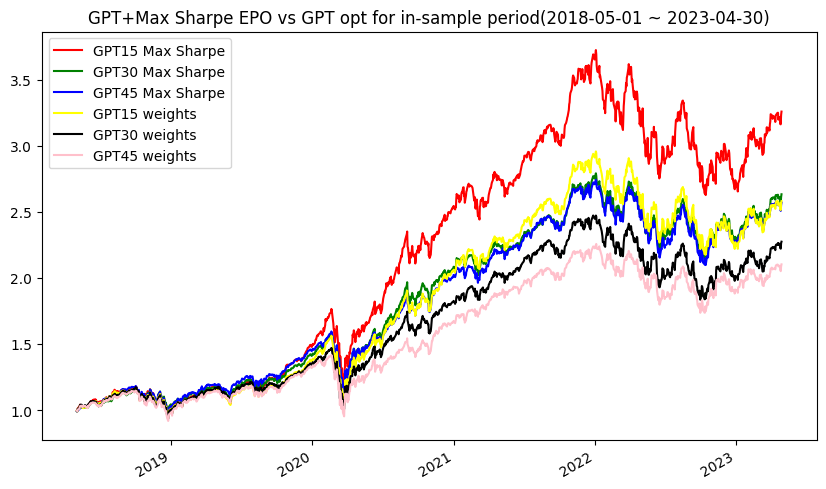

In [52]:
plt.figure(figsize=(10,6))
plt.title("GPT+Max Sharpe EPO vs GPT opt for in-sample period(2018-05-01 ~ 2023-04-30)")

msf_15.plot(label='GPT15 Max Sharpe', color='red')
msf_30.plot(label='GPT30 Max Sharpe', color='green')
msf_45.plot(label='GPT45 Max Sharpe', color='blue')
gpt_15_in.plot(label='GPT15 weights', color='yellow')
gpt_30_in.plot(label='GPT30 weights', color='black')
gpt_45_in.plot(label='GPT45 weights', color='pink')

plt.legend()
plt.show()

### out-of-sample 누적 수익률 확인 2023-05-01 ~ 2023-10-10

In [53]:
# out-of-sample
msf_15 = max_sharpe_epo_cum_ret(stocks_15, msp_epo_15, '2023-04-29', '2023-10-10')
msf_30 = max_sharpe_epo_cum_ret(stocks_30, msp_epo_30, '2023-04-29', '2023-10-10')
msf_45 = max_sharpe_epo_cum_ret(stocks_45, msp_epo_45, '2023-04-29', '2023-10-10')

100%|██████████| 45/45 [00:00<00:00, 848.87it/s]


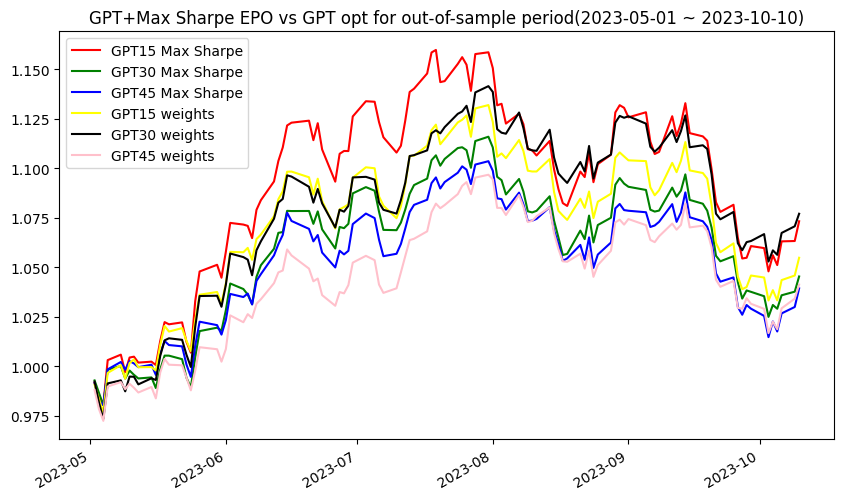

In [54]:
plt.figure(figsize=(10,6))
plt.title("GPT+Max Sharpe EPO vs GPT opt for out-of-sample period(2023-05-01 ~ 2023-10-10)")

msf_15.plot(label='GPT15 Max Sharpe', color='red')
msf_30.plot(label='GPT30 Max Sharpe', color='green')
msf_45.plot(label='GPT45 Max Sharpe', color='blue')
gpt_15_out.plot(label='GPT15 weights', color='yellow')
gpt_30_out.plot(label='GPT30 weights', color='black')
gpt_45_out.plot(label='GPT45 weights', color='pink')

plt.legend()
plt.show()

## Max Expexcted Returns

In [55]:
def max_return_epo(dict):
    df = downloads(dict, "2018-05-01", "2023-04-30")

    mu = expected_returns.mean_historical_return(df) # pfo mean 
    S = risk_models.sample_cov(df) # cov
    S = risk_models.cov_to_corr(S) # cov -> corr
    stds = np.sqrt(np.diag(S))
    theta = 0.75 # shrinkage parameter
    identity_matrix = np.eye(S.shape[0])  # identity matrix
    S = (1-theta)* S + theta * identity_matrix
    S = risk_models.corr_to_cov(S, stds)
    ef = EfficientFrontier(mu, S, solver='ECOS')
    ef.add_constraint(lambda x: x.sum() == 1,)

    n_assets = len(mu)  # 자산 수
    min_weights = 0.5 * 1 / n_assets  # 각 자산별 최소 weight
    max_weights = 2 * 1 / n_assets
    
    for asset in mu.index:
        num = mu.index.get_loc(asset)
        ef.add_constraint(lambda w: w[num] <= max_weights)
        ef.add_constraint(lambda w: w[num] >= min_weights)

    w_opt = ef._max_return()

    w_clean = ef.clean_weights()
    print()
    ef.portfolio_performance(verbose=True) 
    # print(w_clean) # 가중치 확인
    max_weight_asset = max(w_clean, key=w_clean.get)
    max_weight_value = w_clean[max_weight_asset]

    print()
    print("가장 큰 가중치를 가진 자산:", max_weight_asset)
    print("가장 큰 가중치:", max_weight_value)

    return w_clean

In [56]:
max_ret_epo_15 = max_return_epo(stocks_15)
max_ret_epo_30 = max_return_epo(stocks_30)
max_ret_epo_45 = max_return_epo(stocks_45)

100%|██████████| 15/15 [00:00<00:00, 348.76it/s]



Expected annual return: 24.7%
Annual volatility: 44.6%
Sharpe Ratio: 0.51

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.13333


100%|██████████| 30/30 [00:00<00:00, 370.28it/s]



Expected annual return: 18.2%
Annual volatility: 39.2%
Sharpe Ratio: 0.41

가장 큰 가중치를 가진 자산: MSFT
가장 큰 가중치: 0.06667


100%|██████████| 45/45 [00:00<00:00, 284.74it/s]



Expected annual return: 17.3%
Annual volatility: 36.7%
Sharpe Ratio: 0.42

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.04444


In [57]:
print('MAX Return EPO 15 tickers')
print(list(max_ret_epo_15))

print('MAX Return EPO 30 tickers')
print(list(max_ret_epo_30))

print('MAX Return EPO 45 tickers')
print(list(max_ret_epo_45))

MAX Return EPO 15 tickers
['AAPL', 'AMZN', 'NVDA', 'JPM', 'PG', 'PFE', 'JNJ', 'KO', 'XOM', 'NEE', 'GOOGL', 'MSFT', 'TSLA', 'NKE', 'BAC']
MAX Return EPO 30 tickers
['MSFT', 'AMZN', 'NVDA', 'AAPL', 'GOOGL', 'ADBE', 'JNJ', 'PFE', 'MRK', 'ABT', 'PG', 'KO', 'JPM', 'GS', 'CAT', 'CVX', 'XOM', 'BA', 'TSLA', 'NEE', 'NKE', 'VZ', 'CRM', 'UNH', 'WMT', 'QCOM', 'BAC', 'V', 'MCD', 'INTC']
MAX Return EPO 45 tickers
['AAPL', 'GOOGL', 'MSFT', 'NVDA', 'AMD', 'ORCL', 'CRM', 'INTC', 'CSCO', 'JPM', 'GS', 'BAC', 'MS', 'AXP', 'C', 'JNJ', 'UNH', 'PFE', 'ABBV', 'TSLA', 'AMGN', 'GILD', 'PG', 'KO', 'NKE', 'PEP', 'COST', 'WMT', 'TGT', 'XOM', 'CVX', 'NEE', 'DUK', 'SO', 'SLB', 'MMM', 'CAT', 'HON', 'GE', 'ADP', 'AMZN', 'META', 'HD', 'VZ', 'MRK']


In [58]:
max_ret_epo_15_w = max_return_epo(stocks_15).values()
max_ret_epo_30_w = max_return_epo(stocks_30).values()
max_ret_epo_45_w = max_return_epo(stocks_45).values()

100%|██████████| 15/15 [00:00<00:00, 428.50it/s]


Expected annual return: 24.7%
Annual volatility: 44.6%
Sharpe Ratio: 0.51

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.13333


100%|██████████| 30/30 [00:00<00:00, 434.68it/s]


Expected annual return: 18.2%
Annual volatility: 39.2%
Sharpe Ratio: 0.41

가장 큰 가중치를 가진 자산: MSFT
가장 큰 가중치: 0.06667



100%|██████████| 45/45 [00:00<00:00, 424.43it/s]



Expected annual return: 17.3%
Annual volatility: 36.7%
Sharpe Ratio: 0.42

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.04444


In [59]:
print('MAX Return EPO 15 weights')
print(list(max_ret_epo_15_w))

print('MAX Return EPO 30 weights')
print(list(max_ret_epo_30_w))

print('MAX Return EPO 45 weights')
print(list(max_ret_epo_45_w))

MAX Return EPO 15 weights
[0.13333, 0.03333, 0.13333, 0.03333, 0.13333, 0.03333, 0.03333, 0.03333, 0.03333, 0.03333, 0.03333, 0.13333, 0.13333, 0.03333, 0.03333]
MAX Return EPO 30 weights
[0.06667, 0.01667, 0.06667, 0.06667, 0.06667, 0.01667, 0.01667, 0.01667, 0.06667, 0.06667, 0.06667, 0.01667, 0.01667, 0.01667, 0.01667, 0.01667, 0.01667, 0.01667, 0.06667, 0.01667, 0.01667, 0.01667, 0.01667, 0.06667, 0.01667, 0.06667, 0.01667, 0.01667, 0.01667, 0.01667]
MAX Return EPO 45 weights
[0.04444, 0.04444, 0.04444, 0.04444, 0.04444, 0.04444, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.04444, 0.01111, 0.01111, 0.04444, 0.01111, 0.01111, 0.04444, 0.01111, 0.04444, 0.04444, 0.04444, 0.01111, 0.04444, 0.01111, 0.01111, 0.04444, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.04444]


In [60]:
def max_ret_epo_cum_ret(dic, result, start_date, end_date):
    data = downloads(dic, start_date, end_date)
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(result))
    cum_ret = (1 + pfo_ret).cumprod()

    return cum_ret

### in-sample 누적 수익률 확인 2018-05-01 ~ 2023-04-30

In [61]:
# in-sample
max_15 = max_ret_epo_cum_ret(stocks_15, max_ret_epo_15, '2018-05-01', '2023-04-30')
max_30 = max_ret_epo_cum_ret(stocks_30, max_ret_epo_30, '2018-05-01', '2023-04-30')
max_45 = max_ret_epo_cum_ret(stocks_45, max_ret_epo_45, '2018-05-01', '2023-04-30')

100%|██████████| 45/45 [00:00<00:00, 445.44it/s]


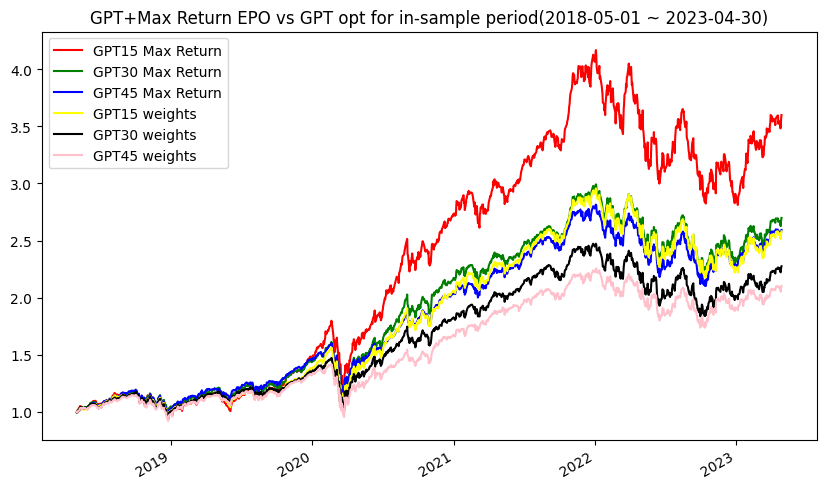

In [62]:
plt.figure(figsize=(10,6))
plt.title("GPT+Max Return EPO vs GPT opt for in-sample period(2018-05-01 ~ 2023-04-30)")

max_15.plot(label='GPT15 Max Return', color='red')
max_30.plot(label='GPT30 Max Return', color='green')
max_45.plot(label='GPT45 Max Return', color='blue')
gpt_15_in.plot(label='GPT15 weights', color='yellow')
gpt_30_in.plot(label='GPT30 weights', color='black')
gpt_45_in.plot(label='GPT45 weights', color='pink')

plt.legend()
plt.show()

### out-of-sample 누적 수익률 확인 2023-05-01 ~ 2023-10-10

In [63]:
# out-of-sample
max_15 = max_ret_epo_cum_ret(stocks_15, max_ret_epo_15, '2023-05-01', '2023-10-10')
max_30 = max_ret_epo_cum_ret(stocks_30, max_ret_epo_30, '2023-05-01', '2023-10-10')
max_45 = max_ret_epo_cum_ret(stocks_45, max_ret_epo_45, '2023-05-01', '2023-10-10')

100%|██████████| 15/15 [00:00<00:00, 833.15it/s]


100%|██████████| 45/45 [00:00<00:00, 899.80it/s]


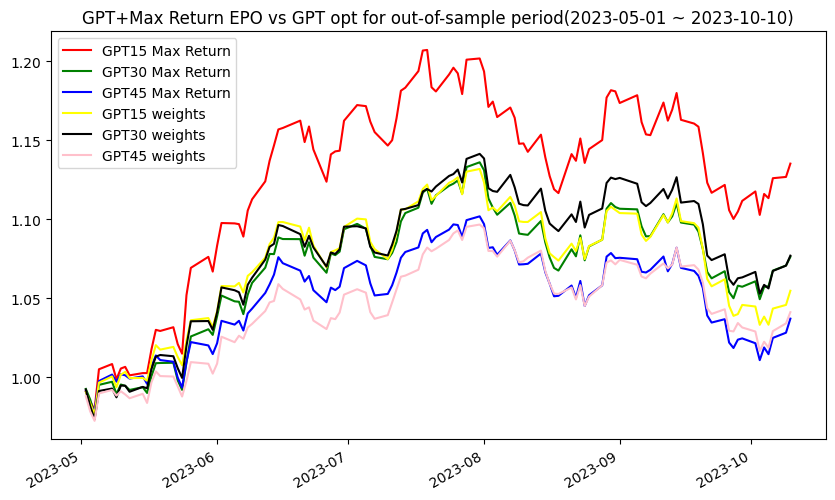

In [64]:
plt.figure(figsize=(10,6))
plt.title("GPT+Max Return EPO vs GPT opt for out-of-sample period(2023-05-01 ~ 2023-10-10)")

max_15.plot(label='GPT15 Max Return', color='red')
max_30.plot(label='GPT30 Max Return', color='green')
max_45.plot(label='GPT45 Max Return', color='blue')
gpt_15_out.plot(label='GPT15 weights', color='yellow')
gpt_30_out.plot(label='GPT30 weights', color='black')
gpt_45_out.plot(label='GPT45 weights', color='pink')

plt.legend()
plt.show()